In [2]:
import gc
from copy import deepcopy
import numpy as np
import pandas as pd
from random import randint

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from keras import backend as K
from sklearn.model_selection import TimeSeriesSplit

from datetime import datetime
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adam, RMSprop
from keras.layers import Input, Conv2D, UpSampling2D, Dropout, LeakyReLU, BatchNormalization, Activation, Add, Subtract
from keras.layers.merge import Concatenate
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
# from keras.applications import VGG16
from keras import initializers
from keras import regularizers
from keras import backend as K

# from libs.pconv_model_UNet import PConvUnet
from keras.models import load_model  

from copy import deepcopy
from libs.util import random_mask, mix_mask

# Settings
MAX_BATCH_SIZE = 64

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [3]:
matrix_length = 32

matrix_df = pd.read_csv('./data/trafficV_M.csv', index_col=0, parse_dates=True)

In [367]:

def createTrainArray(week_history_num=0, minute_history_num=0):
    week_delta_list = [pd.Timedelta(i+1, unit='W') for i in range(week_history_num)]
    minute_delta_list = [pd.Timedelta((i+1)*15, unit='m') for i in range(minute_history_num)]
    # 参考历史数据时间点list
    delta_list = week_delta_list+minute_delta_list
    print(delta_list)
    
    set_up_time = pd.Timedelta(week_history_num, unit='W')
    # 根据历史数据选取多少，重新构建数据集
    # 相当于去除最开始week_history_num个周的数据，因为这些数据无法找到更前的数据
    train_df = matrix_df.truncate(before=matrix_df.index.min() + set_up_time)
    
    train_ago_array_tuple = tuple([np.array(matrix_df.loc[train_df.index - i]).reshape(-1, matrix_length, matrix_length, 1) for i in delta_list])
    train_df = np.array(train_df).reshape(-1, matrix_length, matrix_length, 1)
    # concatenate保持 待修复数据在前，参考历史数据在后。与random_mask函数生成mask相一致
    train_array = np.concatenate((train_df,)+train_ago_array_tuple, axis=3)
    print(train_array.shape)
    return train_array

In [368]:
week_history_num = 2
minute_history_num = 3

channel_num = week_history_num +minute_history_num +1
smooth_time = channel_num-1

train_array = createTrainArray(week_history_num, minute_history_num)
X_train, X_test = train_test_split(train_array, test_size = 0.1, shuffle=False)
# X_train, X_test = train_test_split(train_array, test_size = 0.1, random_state=42, shuffle=False)

# X_train = train_array[:16704-900-900]
# X_val = train_array[16704-900-900:16704-900]
# X_test = train_array[16704-900:]

[Timedelta('7 days 00:00:00'), Timedelta('14 days 00:00:00'), Timedelta('0 days 00:15:00'), Timedelta('0 days 00:30:00'), Timedelta('0 days 00:45:00')]
(16032, 32, 32, 6)


In [369]:
matrix_shape = (matrix_length, matrix_length, channel_num)
true_volume_shape = (matrix_length, matrix_length, 1)
history_volume_shape = (matrix_length, matrix_length, channel_num)

In [370]:
epoch_steps = X_train.shape[0] // MAX_BATCH_SIZE
val_steps = X_test.shape[0] // MAX_BATCH_SIZE
epoch_steps, val_steps

(225, 25)

In [371]:
# 以第一数据为例. 第一列为待预测数据
# 第一例：1.15 0:00  二：1.8 0:00  三：1.1 0:00  四：1.14 23:45  五：1.14 23:30  六：1.14 23:15
# X_train[0]

In [372]:
rand_size = 204
mask_type = 'mix'
block_size = (14, 14)

# 单个矩阵mask
# rand_mask = random_mask(matrix_length, matrix_length, size=rand_size, channels=channel_num, smooth_time=smooth_time, type=mask_type, block_size=block_size)
# 混合矩阵mask
rand_mask = mix_mask(matrix_length, matrix_length, size=rand_size, channels=channel_num, smooth_time=smooth_time, type=mask_type, block_size=block_size)

# 堆叠成多个mask，方便对batch数据进行处理
mask = np.stack([rand_mask for _ in range(MAX_BATCH_SIZE)], axis=0)

In [498]:
rand_mask = np.array([])
with open('./data/dataRecovery/mix_100/mix_100point_mask.data','rb') as f:
    rand_mask = pickle.load(f)

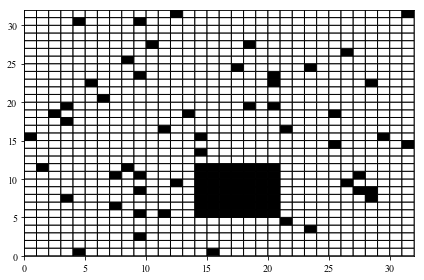

In [500]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 1)
ax.pcolor(rand_mask[:,:,0], edgecolors='k', linewidths=1, cmap ='gray')

plt.rcParams['figure.figsize'] = (6.0, 6.0) # 设置figure_size尺寸

fig.tight_layout()
plt.show()

In [501]:
dump_name = 'mix_100point'
# mask_dump_name = './data/dataRecovery/'+dump_name+'_mask.data'
# import pickle
# with open(mask_dump_name,'wb') as f:
#     pickle.dump(rand_mask,f)

In [502]:
import math

def l2(y_true, y_pred):
    size = 0
    if mask_type == 'rand':
        if rand_size<=1:
            size = int((matrix_length * matrix_length) * rand_size)
        else:
            size = rand_size
    if mask_type == 'block':
        size = block_size[0]*block_size[1]
        
    if mask_type == 'mix':
        size = block_size[0]*block_size[1]+rand_size
        
    if size == 0:
        raise Exception("size == 0")
        
    return math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/size)

def l1(y_true, y_pred):
    size = 0
    if mask_type == 'rand':
        if rand_size<=1:
            size = int((matrix_length * matrix_length) * rand_size)
        else:
            size = rand_size
    if mask_type == 'block':
        size = block_size[0]*block_size[1]
    if mask_type == 'mix':
        size = block_size[0]*block_size[1]+rand_size
        
    if size == 0:
        raise Exception("size == 0")
    return np.sum(np.mean(np.abs(y_true - y_pred), axis=0))/size

def mape(y_true, y_pred):
    size = 0
    if mask_type == 'rand':
        if rand_size<=1:
            size = int((matrix_length * matrix_length) * rand_size)
        else:
            size = rand_size
    if mask_type == 'block':
        size = block_size[0]*block_size[1]
    if mask_type == 'mix':
        size = block_size[0]*block_size[1]+rand_size
      
    if size == 0:
        raise Exception("size == 0")
        
    return np.sum(np.mean((np.abs(y_true - y_pred)/y_true)*100, axis=0))/size



In [503]:
# 加载数据
def load_data(volume_matrix, batch_size=MAX_BATCH_SIZE):
    n_batches=batch_size
    len_of_matrix = len(volume_matrix)

    batch_i = 0
    while ((batch_i+1)*batch_size < len_of_matrix):
        batch_matrix = volume_matrix[batch_i*batch_size: (batch_i+1)*batch_size]
        masked = deepcopy(batch_matrix)
        # true_volume为待修复数据， history_volume为历史数据及当前残差待修复数据
        true_volume = deepcopy(batch_matrix[:, :, :, :1])
        # mask==1代表有效采集点，0代表待预测采集点
        traffic_mean = masked[mask==1].mean()
        # 待预测点的值用已知值的平均值初始化
        masked[mask==0] = traffic_mean
        history_volume = deepcopy(masked)
        
        batch_i+=1

        yield true_volume, history_volume

In [504]:
def l2_loss(y_true, y_pred):
        """Calculate the L1 loss used in all loss calculations"""
        if K.ndim(y_true) == 4:
            return K.sum(K.square(y_pred - y_true), axis=[1,2,3])
        elif K.ndim(y_true) == 3:
            return K.sum(K.square(y_pred - y_true), axis=[1,2])
        else:
            raise NotImplementedError("Calculating L1 loss on 1D tensors? should not occur for this network")

# 缺失点mse
def loss_hole(y_true, y_pred):
    return l2_loss((1-mask) * y_true, (1-mask) * y_pred)

# 非缺失点mse
def loss_bg(y_true, y_pred):
    return l2_loss(mask * y_true, mask * y_pred)

def loss_fuc(y_true, y_pred):
    return loss_hole(y_true, y_pred)*3 + loss_bg(y_true, y_pred)

In [505]:
kernel_init = 'glorot_uniform'
bias_init = 'zeros'

# kernel_init = initializers.he_uniform()
# bias_init = initializers.he_uniform()
kernel_regul = regularizers.l2(1)
activity_regul = regularizers.l2(1)

learn_rate = 0.0002

# ResNet block
def identity_block(X, filters, f):

    F1, F2 = filters

    X_shortcut = X

    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F1, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(X)

    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same',
               kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

# ENCODER
def encoder_layer(img_in, filters, kernel_size, bn=True, resid=True):
    # conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same')(img_in)
    conv = img_in
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
#             conv = MaxPooling2D((2, 2))(conv)


    if resid:
        conv = identity_block(conv, (filters, filters), kernel_size)

    return conv

# DECODER
def decoder_layer(img_in, e_conv, filters, kernel_size, bn=True, resid=True):
    # up_img = UpSampling2D(size=(2,2))(img_in)
    up_img = img_in
    concat_img = Concatenate(axis=3)([e_conv,up_img])
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1, 1), padding='same',
                  kernel_initializer=kernel_init, bias_initializer=bias_init,
              kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(concat_img)
    if bn:
        conv = BatchNormalization()(conv)
    conv = LeakyReLU(alpha=0.1)(conv)

    if resid:
        conv = identity_block(conv, (filters, filters), kernel_size)
    return conv



def build_unet():      

    # INPUTS
    history_traffic_volume = Input(shape=history_volume_shape)

    # kernel_init = initializers.he_normal()
    # bias_init = initializers.he_normal()
    kernel_init = 'glorot_uniform'
    bias_init = 'zeros'

#         kernel_init = initializers.he_uniform()
#         bias_init = 'Orthogonal'
    kernel_regul = regularizers.l2(1)
    activity_regul = regularizers.l2(1)

    filters_base = 32
    e_conv1_head = Conv2D(filters=filters_base, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(history_traffic_volume)
#         e_conv1_head = Conv2D(filters=filters_base*1, kernel_size=3, strides=1, padding='same',
#                               kernel_initializer=kernel_init, bias_initializer=bias_init,
#                       kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv1_head)
    e_conv1_tail = AveragePooling2D((2, 2))(e_conv1_head)
    e_conv1 = encoder_layer(e_conv1_tail, filters_base, 3, bn=False)

    e_conv2_head = Conv2D(filters=filters_base*2, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv1)
    e_conv2_tail = AveragePooling2D((2, 2))(e_conv2_head)
    e_conv2 = encoder_layer(e_conv2_tail, filters_base*2, 3)

    e_conv3_head = Conv2D(filters=filters_base*4, kernel_size=3, strides=1, padding='same',
                          kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(e_conv2)
    e_conv3_tail = AveragePooling2D((2, 2))(e_conv3_head)
    d_conv3_head = encoder_layer(e_conv3_tail, filters_base*4, 3)
    resid1 = Add()([e_conv3_tail, d_conv3_head])
    d_conv3_tail = UpSampling2D(size=(2, 2))(resid1)


    d_conv4_head = decoder_layer(d_conv3_tail, e_conv3_head, filters_base*2, 3)
    resid2 = Add()([d_conv4_head, e_conv2_tail])
    d_conv4_tail = UpSampling2D(size=(2, 2))(resid2)


    d_conv5_head = decoder_layer(d_conv4_tail, e_conv2_head, filters_base*1, 3)
    resid3 = Add()([d_conv5_head, e_conv1_tail])
    d_conv5_tail = UpSampling2D(size=(2, 2))(resid3)

    d_conv6_head = decoder_layer(d_conv5_tail, e_conv1_head, filters_base//2, 3, bn=False)


    outputs = Conv2D(1, 1, activation = 'relu', kernel_initializer=kernel_init, bias_initializer=bias_init,
                  kernel_regularizer=kernel_regul, bias_regularizer=activity_regul)(d_conv6_head)

    # Setup the model inputs / outputs
    model = Model(inputs=history_traffic_volume, outputs=outputs)

    # Compile the model RMSprop
    model.compile(
        optimizer = Adam(lr=learn_rate),
#         loss='mse'
        loss = loss_hole
    )

    return model

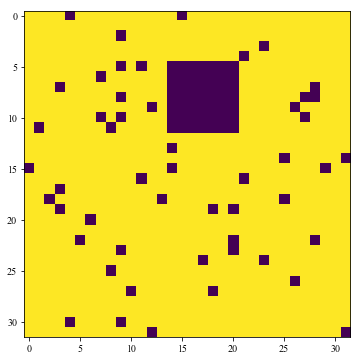

In [506]:
test_masked = deepcopy(X_test)
test_true_volume = deepcopy(X_test[:, :, :, :1])

test_length = len(X_test)
test_mask = np.stack([rand_mask for _ in range(test_length)], axis=0)

test_traffic_mean = X_test[test_mask==1].mean()
test_masked[test_mask==0] = test_traffic_mean
test_history_volume = deepcopy(test_masked)

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.imshow(rand_mask[:,:,0])

In [507]:
lr_step = []
l2_validation = []

unet = build_unet()


def train(train_matrix, epochs, batch_size=MAX_BATCH_SIZE, learn_rate=0.01):

    min_mse = 999
    start_time = datetime.now()
    print("train start "+str(start_time))

    for epoch in range(epochs):
        if epoch>100 and epoch % 10 == 0 and epoch != 0:
            unet_lr = K.get_value(unet.optimizer.lr)
            if unet_lr>0.0001:
                K.set_value(unet.optimizer.lr, unet_lr*0.9)
                
        for batch_i, (true_volume, history_volume) in enumerate(load_data(train_matrix,batch_size)):
            # true_volume 真实待预测路网交通量  history_volume 路网交通量历史数据
            #  训练 unet
            #  训练 Generator
            g_loss = unet.train_on_batch(history_volume, true_volume)


        elapsed_time = datetime.now() - start_time
        # Plot the progress
        y_pred = unet.predict(test_history_volume)
        
        y_true = (1-test_mask[:,:,:,:1])*test_true_volume
        y_pred = (1-test_mask[:,:,:,:1])*y_pred
        l2_epoch_validation = l2(y_true, y_pred)
        l1_epoch_validation = l1(y_true, y_pred)
        
        y_pred[y_true==0] += 1
        y_true[y_true==0] += 1
        mape_epoch_validation = mape(y_true, y_pred)
        
        lr_step.append(K.get_value(unet.optimizer.lr))
        l2_validation.append(l2_epoch_validation)
        if epoch%1==0:
#             print("unet lr:"+ str(K.get_value(unet.optimizer.lr)))
            print ("[Epoch %d/%d]  [mse: %f] [mae: %f] [mape: %f] [G loss: %f] time: %s" % (epoch+1, epochs,
                                                                    l2_epoch_validation,
                                                                    l1_epoch_validation,
                                                                    mape_epoch_validation,
                                                                    g_loss,
                                                                    elapsed_time))
    
        if(l2_epoch_validation>14.9 and l2_epoch_validation<15.3):
            unet.save_weights('./model/dataRecorvey20191109/tmp/mix_400point.h5')
            min_mse = l2_epoch_validation
            break

In [508]:
# train(X_train, epochs=200, batch_size=MAX_BATCH_SIZE, learn_rate=learn_rate)

In [509]:
# unet.save_weights('./model/dataRecorvey20191109/runet_1024.h5')
# unet.load_weights('./model/RUnet/unet_60epoch_18rmse.h5')

In [510]:
# y_pred = unet.predict(test_history_volume)

# # 仅对缺失数据进行l2评价。（对预测来说既对第一层进行评价，验证）
# y_true = (1-test_mask[:,:,:,:1])*test_true_volume

# l2(y_true, y_pred), l1(y_true, y_pred)

In [511]:
# # 存储模型
min_model = build_unet()
# # min_model.load_weights('./model/dataRecorvey20191109/tmp/min_runet.h5')
min_model.load_weights('./data/dataRecovery/mix_100/mix_100point_11.74.h5')

In [512]:
# 存储模型
y_pred = min_model.predict(test_history_volume)

# 仅对缺失数据进行l2评价。（对预测来说既对第一层进行评价，验证）
y_true = (1-test_mask[:,:,:,:1])*test_true_volume
y_pred = (1-test_mask[:,:,:,:1])*y_pred

l2(y_true, y_pred), l1(y_true, y_pred)

(5.870798295358873, 1.9215897971245397)

In [513]:
sum((1-test_mask[:,:,:,:1])[0].reshape(1024) == 1)

100

In [514]:
math.sqrt(np.sum(np.mean(np.square(y_true - y_pred), axis=0))/400)

5.870798295358873

In [515]:
np.sqrt(np.mean(np.square(y_true - y_pred), axis=0)).reshape(1024).mean()

1.0569499610895519

In [516]:
qweqweqeqweqew

NameError: name 'qweqweqeqweqew' is not defined

In [522]:
# 选取修复点
mask_tf_matrix = ((1-test_mask[:,:,:,:1])[0].reshape(1024) == 1)
mask_result_point = np.array([])
# road_net_result = ((np.mean(np.abs(y_true-y_pred), axis=0)).reshape(1024))   #  MAE  路网最终结果，如整个路网的mape平均值 （32，32，1）
# road_net_result = ((np.mean(np.abs(y_true-y_pred)/y_true, axis=0)).reshape(1024))*100  #  MAPE  路网最终结果，如整个路网的mape平均值 （32，32，1）
road_net_result = np.sqrt(np.mean(np.square(y_true - y_pred), axis=0)).reshape(1024)   #  RMSE  路网最终结果，如整个路网的mape平均值 （32，32，1）


for i in range(len(mask_tf_matrix)):
    if(mask_tf_matrix[i]):
        mask_result_point = np.append(mask_result_point, road_net_result[i])

mask_result_dump_name = './data/dataRecovery/'+dump_name+'_rmse_result.data'
with open(mask_result_dump_name,'wb') as f:
    pickle.dump(mask_result_point,f)

In [521]:
mask_result_point.mean()

4.628348621451964

In [ ]:
dump_name

In [ ]:
mask_result_point.mean()

In [ ]:
# df = pd.DataFrame(mask_result_point)
# df.insert(1,'b',1)
# df.columns = ['a','b']

# df1 = pd.DataFrame(mask_point1)
# df1.insert(1,'b',2)
# df1.columns = ['a','b']

# df_total = pd.concat([df, df1])
# df.shape

In [ ]:
# 路网采集点平均mape分布
import seaborn as sns
# font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize=(8, 5))
x_labels=['']
# spacial_mape = (np.mean(np.abs(y_true-y_pred)/y_true, axis=0)).reshape(1024)

# sns.swarmplot(x='b', y='a', data=df_total, size=5)
sns.swarmplot(data=mask_result_point, size=5)

ax.set_xticklabels(x_labels)
plt.ylabel('MAPE(%)', fontsize=22)

plt.grid(True)

# plt.savefig('./pic/毕设/mape分析_runet点图_实验一.jpg', dpi=300)

In [ ]:
# y_pred[y_true==0] += 1
# y_true[y_true==0] += 1

# mape(y_true, y_pred)
# # 5.013244341615349

In [ ]:
# y_pred[y_true==0] += 1
# y_true[y_true==0] += 1

# mape(y_true, y_pred)
# # 4.429743492502313

In [ ]:
posX = 15
posY = 15
startX = 475
gapX = 500

zero_line = np.random.randint(0, 1, (gapX,))

y = test_true_volume[:, posX, posY, :][startX: startX+gapX]

yf = y_pred[:, posX, posY, :][startX: startX+gapX]

import matplotlib as mpl
import matplotlib.pyplot as plt

x = np.linspace(0, len(y), len(y))
fig, ax = plt.subplots(figsize=(25, 16))
lines = plt.plot(x, yf, 'k^--', x, y, 'ko-', x, yf-y, 'kx-', x, zero_line, 'k-', linewidth=2, markersize=15)
plt.show()

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# 560
pic_num = 560
pic_matrix =y_pred[pic_num].reshape(32, 32, 1)
true_matrix =y_true[pic_num].reshape(32, 32, 1)
fig, axes = plt.subplots(1, 2, figsize=(25, 12))
a = axes[0].imshow(true_matrix[:,:,0], cmap ='binary')
b = axes[1].imshow(pic_matrix[:,:,0], cmap ='binary')
# fig.colorbar(a, shrink=1)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

pic_num = 260
pic_matrix =y_pred[pic_num].reshape(32, 32, 1)
true_matrix =y_true[pic_num].reshape(32, 32, 1)

# pic_shape = pic_matrix.shape
# Load mask
# mask = random_mask(pic_shape[0], pic_shape[1], size=0.3)
# mask = random_mask(pic_shape[0], pic_shape[1], size=0.9, type='block', block_size=(25, 25))

# Image + mask
# masked_img = deepcopy(pic_matrix)
# masked_img = (pic_matrix - pic_matrix.min())/(pic_matrix.max() - pic_matrix.min())*255
# masked_img[rand_mask[:,:,0]==0] = 0

# Show side by side
_, axes = plt.subplots(1, 2, figsize=(25, 12))
a = axes[0].imshow(true_matrix[:,:,0])
b = axes[1].imshow(pic_matrix[:,:,0])
# axes[2].imshow(rand_mask[:,:,0]*255, cmap ='gray')
# axes[3].imshow(masked_img[:,:,0])

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

start_time = 1600
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 10))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

In [ ]:
start_time = 3600
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

In [ ]:
start_time = 0
y = y_true.reshape(-1,)[start_time: start_time+100]
x = np.linspace(0, len(y), len(y))

yi = y_pred.reshape(-1,)[start_time: start_time+100]
xi = np.linspace(0, len(yi), len(yi))
fig, ax = plt.subplots(figsize=(25, 6))
# ax.plot(x, y, '.', linewidth=1, markersize=10)
lines = plt.plot(xi, yi, 'k^--', x, y, 'ro-',linewidth=1, markersize=6)
plt.show()

In [ ]:
min_model = build_unet()
min_model.load_weights('./model/dataRecorvey20191109/runet_1024.h5')

y_pred = min_model.predict(test_history_volume)
y_true = test_true_volume
# 仅对缺失数据进行l2评价。（对预测来说既对第一层进行评价，验证）
# y_true = (1-test_mask[:,:,:,:1])*test_true_volume
# y_pred = (1-test_mask[:,:,:,:1])*y_pred

l2(y_true, y_pred), l1(y_true, y_pred)
# (11.085728026573435, 6.957813774885677)

In [ ]:
import matplotlib as mpl
del mpl.font_manager.weight_dict['roman']
mpl.font_manager._rebuild()

from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc")
fontsz = 23

posX = 2
posY = 2
startX = 1230
gapX = 192

zero_line = np.random.randint(0, 1, (gapX,))

y = test_true_volume[:, posX, posY, :][startX: startX+gapX]
yf = y_pred[:, posX, posY, :][startX: startX+gapX]
x = np.linspace(0, len(y), len(y))

fig, ax = plt.subplots(figsize=(15, 5.8))
lines = plt.plot(x, y, x, yf, x,y-yf, x,zero_line)
l1, l2, l3, l4 = lines

plt.setp(lines, markersize=7, linewidth=1.34)
plt.setp(l1, color='k', linestyle='--', marker='o')  # line1 is thick and red
plt.setp(l2, color='grey', linestyle='-', marker='^')  # line2 is thinner and green
plt.setp(l3, color='k', linestyle='-', marker='.')  # line2 is thinner and green
plt.setp(l4, color='k', linestyle='-')  # line2 is thinner and green

plt.ylabel('交通量/ 辆/小时', fontproperties=font, fontsize=fontsz)
plt.xlabel('观测时间点', fontproperties=font, fontsize=fontsz)

qwe = range(0,2000,500)
plt.yticks(qwe, ('0', '500', '1 000', '1 500'))
ax.legend(('真实值', '修复值', '误差'), prop=font, loc=1)
plt.rcParams.update({'font.size': fontsz})
plt.rc('font',family='Times New Roman')
# plt.savefig('RU-Net日交通量预测图.jpg', dpi=300)
plt.show()

In [ ]:
y_pred

In [ ]:
test_true_volume